In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import matplotlib.pyplot as plt

In [2]:
# Generator for streaming in the train and validation data in chunks of 15000
def my_generator(chunks, file):
    while True:
        for data in pd.read_csv(file, chunksize=chunks):
            # Removing NULL values since the count of NULL values is extremely low
            data = data[data['Trip Seconds'].notna()]
            data = data[data['Trip Miles'].notna()]
            data = data[data['Fare'].notna()]
            data = data[data['Trip Start Timestamp'].notna()]
            # Extracting month from Timestamp
            data['month'] = pd.to_datetime(data['Trip Start Timestamp']).dt.month
            x = data[['Trip Seconds', 'Trip Miles', 'month']].to_numpy()
            y = data['Fare'].to_numpy()
            yield x, y

In [3]:
# Neural network model with 2 hidden layers using mean absolute error as the loss metric
NN_model_2021 = Sequential()

# The Input Layer :
NN_model_2021.add(Dense(16, kernel_initializer='normal',input_dim = 3, activation='relu'))

# The Hidden Layer :
NN_model_2021.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_2021.add(Dense(32, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model_2021.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model_2021.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'mse'])


In [4]:
# Lengths of the train and validation data
lengths_2021 = [1803434, 386108, 0]
train_file = 'train_2021.csv'
validation_file = 'validation_2021.csv'
chunksize = 15000

# Model runs with a generator for both the train and validation sets for 10 epochs
history = NN_model_2021.fit(my_generator(chunksize, train_file),
          steps_per_epoch=lengths_2021[0]//chunksize,
          epochs=10,
          verbose=2,
          validation_data=my_generator(chunksize, validation_file), 
          validation_steps = lengths_2021[1]//chunksize
            )

Epoch 1/10
120/120 - 203s - loss: 10.8509 - mean_absolute_error: 10.8509 - mse: 5961.2046 - val_loss: 7.6168 - val_mean_absolute_error: 7.6168 - val_mse: 5255.2656 - 203s/epoch - 2s/step
Epoch 2/10
120/120 - 205s - loss: 6.8707 - mean_absolute_error: 6.8707 - mse: 5744.2549 - val_loss: 5.4500 - val_mean_absolute_error: 5.4500 - val_mse: 4808.7793 - 205s/epoch - 2s/step
Epoch 3/10
120/120 - 202s - loss: 4.2725 - mean_absolute_error: 4.2725 - mse: 5735.9858 - val_loss: 3.8011 - val_mean_absolute_error: 3.8011 - val_mse: 4737.2075 - 202s/epoch - 2s/step
Epoch 4/10
120/120 - 203s - loss: 3.8484 - mean_absolute_error: 3.8484 - mse: 5696.0376 - val_loss: 3.7295 - val_mean_absolute_error: 3.7295 - val_mse: 4724.5713 - 203s/epoch - 2s/step
Epoch 5/10
120/120 - 203s - loss: 3.7718 - mean_absolute_error: 3.7718 - mse: 5560.2798 - val_loss: 3.6873 - val_mean_absolute_error: 3.6873 - val_mse: 4711.9624 - 203s/epoch - 2s/step
Epoch 6/10
120/120 - 264s - loss: 3.7521 - mean_absolute_error: 3.7521 - 

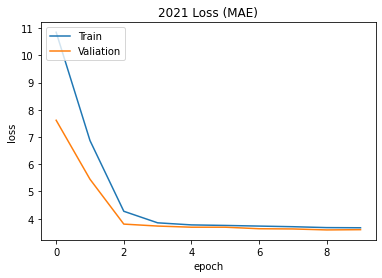

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot of loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('2021 Loss (MAE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Valiation'], loc='upper left')
plt.show()
plt.savefig('2021_loss.png')

In [6]:
# Loading in test data and isolating four relevant columns
test_2021 = pd.read_csv('test_2021.csv')
test_2021 = test_2021[test_2021['Trip Seconds'].notna()]
test_2021 = test_2021[test_2021['Trip Miles'].notna()]
test_2021 = test_2021[test_2021['Fare'].notna()]
test_2021 = test_2021[test_2021['Trip Start Timestamp'].notna()]
test_2021['month'] = pd.to_datetime(test_2021['Trip Start Timestamp']).dt.month
x = test_2021[['Trip Seconds', 'Trip Miles', 'month']]
y = test_2021['Fare']

In [ ]:
# Saving model in a H5py format
NN_model_2021.save('models/NN_model_2021.h5')

In [8]:
# Predicting values using test set
predictions = NN_model_2021.predict(x)

In [13]:
# Evaluating model using test data
NN_model_2021.evaluate(x,y)

12054/12054 [==============================] - 10s 855us/step - loss: 3.4653 - mean_absolute_error: 3.4653 - mse: 4068.6990


[3.4652721881866455, 3.4652721881866455, 4068.698974609375]

/common/home/pr446/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


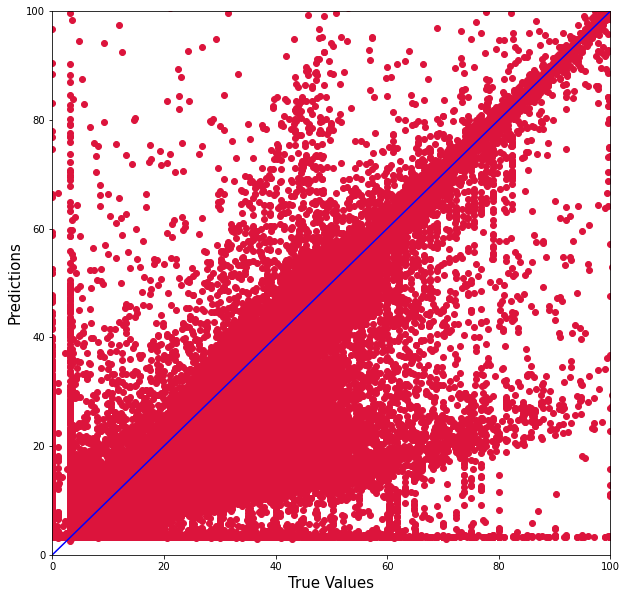

In [10]:
# Plot of actual vs predicted values
y = y.to_numpy()
plt.figure(figsize=(10,10))
plt.scatter(y, predictions, c='crimson')


p1 = max(max(predictions), max(y))
p2 = min(min(predictions), min(y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()